In [1]:
import os
import torch
import pandas as pd
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader
from modules.lifter_2d_3d.dataset.drive_and_act_keypoint_dataset import DriveAndActKeypointDataset
from modules.lifter_2d_3d.model.linear_model.lit_linear_model import LitSimpleBaselineLinear
from modules.utils.visualization import (
    plot_samples
)
from IPython.display import display
from pathlib import Path

pl.seed_everything(1234)

# ------------
# dataset path
# ------------
dataset_root_path = Path('/root/data/processed/drive_and_act/')
keypoint_2d_path = dataset_root_path / 'keypoint_detection_results'
keypoint_3d_path = dataset_root_path / 'annotations'
bbox_file = dataset_root_path / 'person_detection_results'
# ------------
# model
# ------------
image_width = 1280
image_height = 1024
batch_size = 64
max_epoch = 200
val_check_period = 5
early_stopping_patience = 5
# ------------
# saved model path
# ------------
saved_model_path = './saved_lifter_2d_3d_model/linear_model/drive_and_act/A_Pillar_Codriver/predicted_2d/all_actors/'


train_dataset = DriveAndActKeypointDataset(
    prediction_file=(keypoint_2d_path / 'keypoint_detection_train.json').as_posix(),
    annotation_file=(keypoint_3d_path / 'person_keypoints_train.json').as_posix(),
    bbox_file=(bbox_file / 'human_detection_train.json').as_posix(),
    image_width=image_width,
    image_height=image_height,
    # actors=['vp1', 'vp4', 'vp5', 'vp6', 'vp7', 'vp8', 'vp9', 'vp10', 'vp15'],
    actors=['vp1', 'vp2', 'vp3', 'vp4', 'vp5', 'vp6', 'vp7', 'vp8'],
    exclude_ankle=True,
    exclude_knee=True,
    # is_normalize_to_bbox=True,
    # bbox_format='xyxy'

    is_center_to_neck=True,
    is_normalize_to_bbox=False,
    is_normalize_to_pose=True,
    is_normalize_rotation=True
)
val_dataset = DriveAndActKeypointDataset(
    prediction_file=(keypoint_2d_path / 'keypoint_detection_train.json').as_posix(),
    annotation_file=(keypoint_3d_path / 'person_keypoints_train.json').as_posix(),
    bbox_file=(bbox_file / 'human_detection_train.json').as_posix(),
    image_width=image_width,
    image_height=image_height,
    # actors=['vp2', 'vp3'],
    actors=['vp9', 'vp10', 'vp15'],
    exclude_ankle=True,
    exclude_knee=True,
    # is_normalize_to_bbox=True,
    # bbox_format='xyxy'

    is_center_to_neck=True,
    is_normalize_to_bbox=False,
    is_normalize_to_pose=True,
    is_normalize_rotation=True
)
test_dataset = DriveAndActKeypointDataset(
    prediction_file=(keypoint_2d_path / 'keypoint_detection_train.json').as_posix(),
    annotation_file=(keypoint_3d_path / 'person_keypoints_train.json').as_posix(),
    bbox_file=(bbox_file / 'human_detection_train.json').as_posix(),
    image_width=image_width,
    image_height=image_height,
    actors=['vp11', 'vp12', 'vp13', 'vp14'],
    # actors=['vp13', 'vp14', 'vp15'],
    exclude_ankle=True,
    exclude_knee=True,
    # is_normalize_to_bbox=True,
    # bbox_format='xyxy'
    
    is_center_to_neck=True,
    is_normalize_to_bbox=False,
    is_normalize_to_pose=True,
    is_normalize_rotation=True
)
all_activities = train_dataset.activities.union(val_dataset.activities).union(test_dataset.activities)
lit_model = LitSimpleBaselineLinear(exclude_ankle=True, exclude_knee=True, all_activities=all_activities, is_silence=False, learning_rate=1e-3)
print(
    'train_dataset', len(train_dataset),
    'val_dataset', len(val_dataset),
    'test_dataset', len(test_dataset)
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=24)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, num_workers=24)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=24)


model_checkpoint = ModelCheckpoint(monitor='val_loss',mode='min', save_top_k=1)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=early_stopping_patience)

if not os.path.exists(saved_model_path):
    os.makedirs(saved_model_path)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
trainer = pl.Trainer(
    # max_steps=10,
    max_epochs=max_epoch,
    callbacks=[model_checkpoint, early_stopping],
    accelerator=device,
    check_val_every_n_epoch=val_check_period,
    default_root_dir=saved_model_path,
    gradient_clip_val=1.0
)
trainer.fit(lit_model, train_loader, val_loader)

Global seed set to 1234


skipping problematic image 3628
skipping problematic image 5874
skipping problematic image 14835
skipping problematic image 15783
skipping problematic image 17258
skipping problematic image 17259
skipping problematic image 21271
skipping problematic image 21272
skipping problematic image 21273
skipping problematic image 21274
skipping problematic image 21275
skipping problematic image 21276
skipping problematic image 32959
skipping problematic image 33527
skipping problematic image 28113


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


train_dataset 22881 val_dataset 6240 test_dataset 11017


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params
----------------------------------------
0 | model | BaselineModel | 4.3 M 
----------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.105    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

check #0
val MPJPE from: 128 samples : 2831.9754600524902


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

check #1
training loss from 1785 batches: 575.4983288984673
val MPJPE from: 6208 samples : 91.69488400220871


Validation: 0it [00:00, ?it/s]

check #2
training loss from 1785 batches: 130.81424945459312
val MPJPE from: 6208 samples : 83.55310559272766


Validation: 0it [00:00, ?it/s]

check #3
training loss from 1785 batches: 116.08794352837971
val MPJPE from: 6208 samples : 75.42828470468521


Validation: 0it [00:00, ?it/s]

check #4
training loss from 1785 batches: 110.83964301841934
val MPJPE from: 6208 samples : 76.39816403388977


Validation: 0it [00:00, ?it/s]

check #5
training loss from 1785 batches: 108.21668118739329
val MPJPE from: 6208 samples : 77.0738422870636


Validation: 0it [00:00, ?it/s]

check #6
training loss from 1785 batches: 106.80026361087457
val MPJPE from: 6208 samples : 74.02395457029343


Validation: 0it [00:00, ?it/s]

check #7
training loss from 1785 batches: 105.71948704348893
val MPJPE from: 6208 samples : 74.30065423250198


Validation: 0it [00:00, ?it/s]

check #8
training loss from 1785 batches: 104.64438085629492
val MPJPE from: 6208 samples : 74.91369545459747


Validation: 0it [00:00, ?it/s]

check #9
training loss from 1785 batches: 103.76139045888637
val MPJPE from: 6208 samples : 74.27987456321716


Validation: 0it [00:00, ?it/s]

check #10
training loss from 1785 batches: 103.13700935085949
val MPJPE from: 6208 samples : 73.04631173610687


Validation: 0it [00:00, ?it/s]

check #11
training loss from 1785 batches: 102.52304546722844
val MPJPE from: 6208 samples : 73.74954968690872


Validation: 0it [00:00, ?it/s]

check #12
training loss from 1785 batches: 101.89866641906798
val MPJPE from: 6208 samples : 74.08008724451065


Validation: 0it [00:00, ?it/s]

check #13
training loss from 1785 batches: 101.51340100778584
val MPJPE from: 6208 samples : 73.8731175661087


Validation: 0it [00:00, ?it/s]

check #14
training loss from 1785 batches: 101.20543204143603
val MPJPE from: 6208 samples : 73.04727286100388


Validation: 0it [00:00, ?it/s]

check #15
training loss from 1785 batches: 100.92084078060813
val MPJPE from: 6208 samples : 73.28295707702637


In [2]:
with open(f'{saved_model_path}/best_model_path.txt', 'w') as f:
    f.writelines(model_checkpoint.best_model_path)
best_checkpoint_path = model_checkpoint.best_model_path
trainer.test(ckpt_path=best_checkpoint_path, dataloaders=test_loader)

Restoring states from the checkpoint path at saved_lifter_2d_3d_model/linear_model/drive_and_act/A_Pillar_Codriver/predicted_2d/all_actors/lightning_logs/version_53/checkpoints/epoch=49-step=17850.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at saved_lifter_2d_3d_model/linear_model/drive_and_act/A_Pillar_Codriver/predicted_2d/all_actors/lightning_logs/version_53/checkpoints/epoch=49-step=17850.ckpt


Testing: 0it [00:00, ?it/s]

MPJPE: 62.610878525447156
PJPE
                      PJPE
nose             54.978496
left_eye         51.945210
right_eye        50.920233
left_ear         15.104708
right_ear        35.521527
left_shoulder    15.792405
right_shoulder   18.876693
left_elbow       64.732932
right_elbow      66.115421
left_wrist       83.033412
right_wrist     103.379199
left_hip         62.679520
right_hip        60.477262
activities_mpjpe:
{'entering_car': 210.95317097505844, 'sitting_still': 57.048758216745014, 'closing_door_inside': 136.16162761623823, 'opening_bottle': 70.17166630375283, 'fetching_an_object': 151.1379975247079, 'closing_bottle': 77.74129338355934, 'pressing_automation_button': 55.58894098408662, 'drinking': 73.24479937976669, 'opening_backpack': 211.41051705738656, 'placing_an_object': 143.4109853983876, 'eating': 58.44732932180847, 'preparing_food': 119.94114410757037, 'reading_newspaper': 83.67418050316871, 'using_multimedia_display': 96.83225816139255, 'writing': 90.9048775985459

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           mpjpe           │    62.610878525447156     │
└───────────────────────────┴───────────────────────────┘

[{'mpjpe': 62.610878525447156}]

In [3]:
pd.DataFrame(lit_model.test_history[0]['activities_mpjpe'], index=['mpjpe']).T.sort_values('mpjpe')

,mpjpe
pressing_automation_button,55.588941
sitting_still,57.048758
eating,58.447329
reading_magazine,64.810903
interacting_with_phone,69.004768
opening_bottle,70.171666
working_on_laptop,73.022017
drinking,73.244799
closing_bottle,77.741293
reading_newspaper,83.674181


In [4]:
pd.DataFrame(lit_model.test_history[0]['activities_mpjpe'], index=['mpjpe']).T.mean()

mpjpe    127.856301
dtype: float64

[347.3514, 286.7826, 657.2451, 620.2427]
[355.2612, 290.0608, 650.605, 605.4089]
[343.4412, 268.8018, 686.1542, 479.4213]


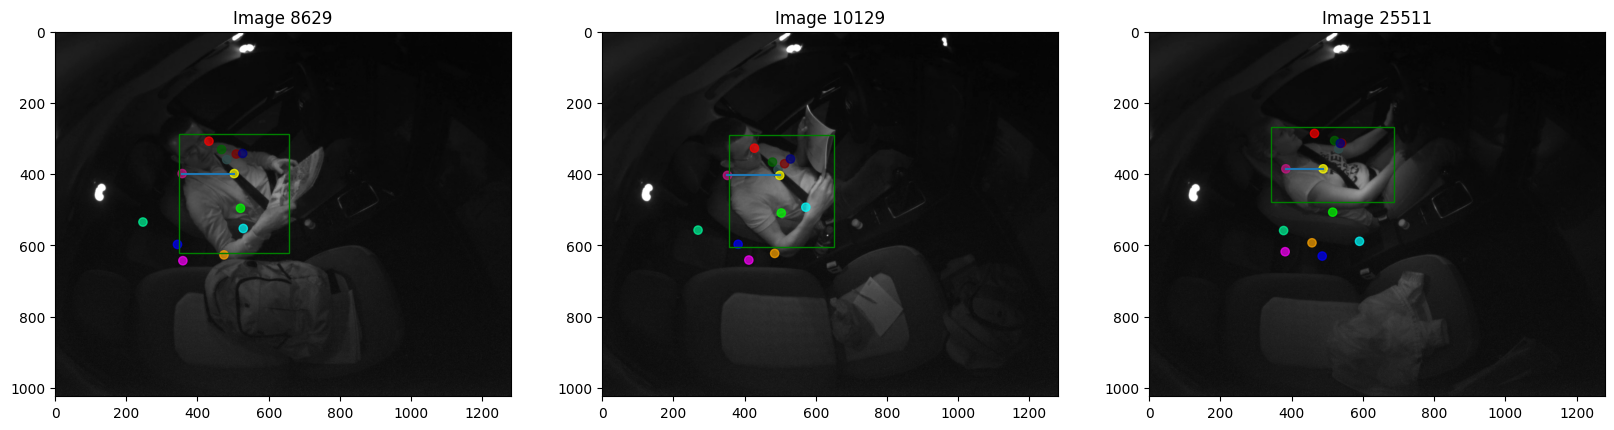

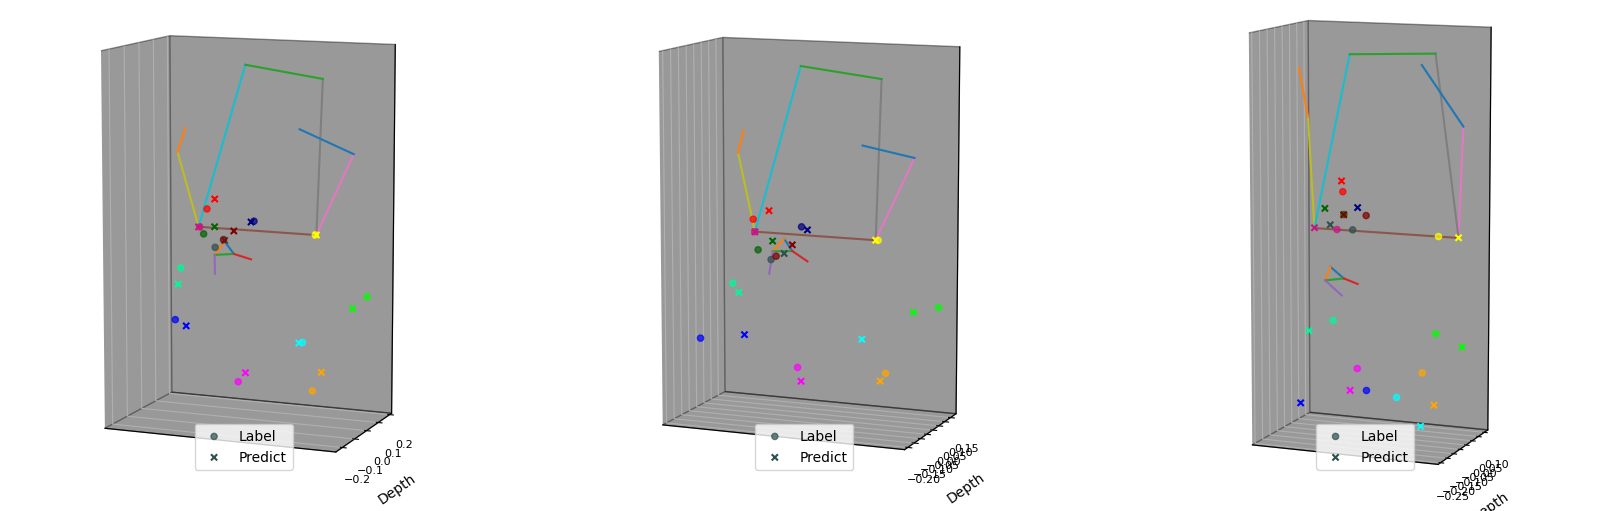

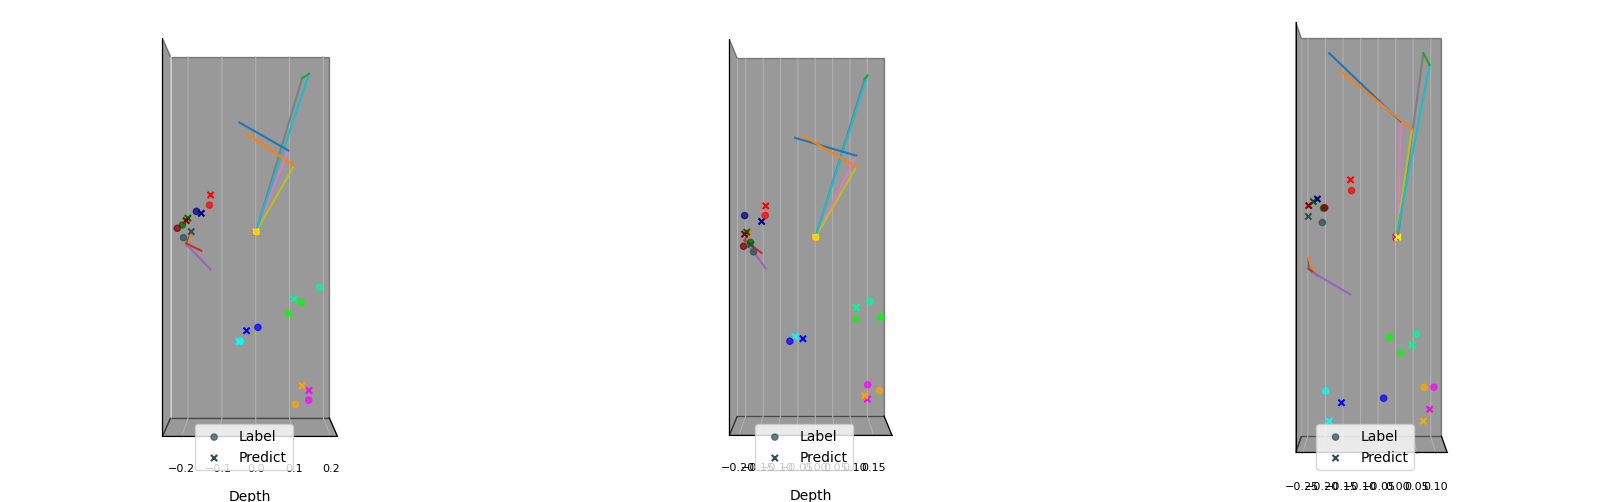

In [5]:
plot_samples(
    dataset_root_path,
    trainer.model,
    test_loader,
    'train',
    img_figsize=(20, 10),
    plot_figsize=(20.5, 10),
    sample_idices=[1000, 2500, 6000],
    is_plot_gt_skeleton=False
)